In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

ModuleNotFoundError: No module named 'bayes_opt'

In [47]:
# 读取数据
data = pd.read_excel('E:\\555.xlsx')

In [48]:
# 划分特征和目标变量
X = data.drop(columns=['self healingefficiency'])
y = data['self healingefficiency']

In [49]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# 定义随机森林回归模型
def rf_cv(n_estimators, max_depth, min_samples_split):
    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  random_state=42)
    # 使用5折交叉验证计算R方值
    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()

In [51]:
# 定义贝叶斯优化函数
def optimize_rf():
    rf_bo = BayesianOptimization(f=rf_cv,
                                 pbounds={'n_estimators': (50, 200),
                                          'max_depth': (3, 10),
                                          'min_samples_split': (2, 10)},
                                 random_state=42)
    rf_bo.maximize(init_points=10, n_iter=40)

    return rf_bo

In [52]:
# 执行贝叶斯优化
opt_results = optimize_rf()

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9086    | 5.622     | 9.606     | 159.8     |
| 2         | 0.9161    | 7.191     | 3.248     | 73.4      |
| 3         | 0.9172    | 3.407     | 8.929     | 140.2     |
| 4         | 0.9181    | 7.957     | 2.165     | 195.5     |
| 5         | 0.9158    | 8.827     | 3.699     | 77.27     |
| 6         | 0.9255    | 4.284     | 4.434     | 128.7     |
| 7         | 0.9194    | 6.024     | 4.33      | 141.8     |
| 8         | 0.9285    | 3.976     | 4.337     | 105.0     |
| 9         | 0.9106    | 6.192     | 8.281     | 79.95     |
| 10        | 0.9189    | 6.6       | 6.739     | 56.97     |
| 11        | 0.9218    | 5.646     | 2.0       | 115.1     |
| 12        | 0.8992    | 9.109     | 10.0      | 104.8     |
| 13        | 0.9256    | 4.326     | 3.372     | 105.5     |
| 14        | 0.9297    | 3.193     | 3.194     | 102.9     |
| 15    

In [53]:
# 输出最佳参数
best_params = opt_results.max['params']
print("最佳参数:")
print(best_params)
# 输出最佳参数和最大R方值
print("Best R2 Score:", opt_results.max['target'])

最佳参数:
{'max_depth': 3.0, 'min_samples_split': 2.0, 'n_estimators': 188.59997809684293}
Best R2 Score: 0.9304433939944821


In [54]:
# 使用最佳参数建立模型
rf_model = RandomForestRegressor(n_estimators=int(best_params['n_estimators']),
                              max_depth=int(best_params['max_depth']),
                              min_samples_split=int(best_params['min_samples_split']),
                              random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=188, random_state=42)

In [55]:
# 在测试集上进行预测
y_pred = rf_model.predict(X_test)

In [56]:
# 计算RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# 计算R方值
r2 = r2_score(y_test, y_pred)
print("R方值:", r2)

RMSE: 0.03248500438038856
R方值: 0.9018349782630267


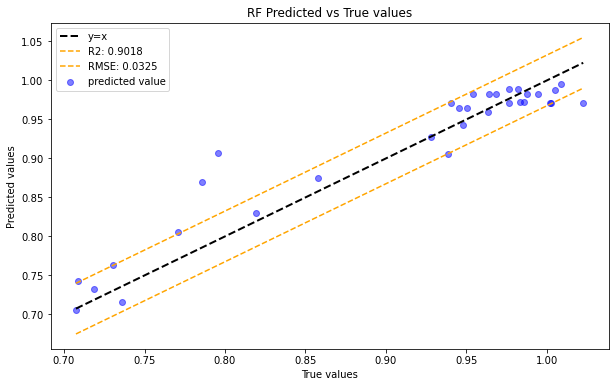

In [57]:
# 绘制预测结果图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.plot([min(y_test), max(y_test)], [min(y_test) + rmse, max(y_test) + rmse], 'orange', linestyle='dashed')
plt.plot([min(y_test), max(y_test)], [min(y_test) - rmse, max(y_test) - rmse], 'orange', linestyle='dashed')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('RF Predicted vs True values')
plt.legend(['y=x', f"R2: {r2:.4f}", f"RMSE: {rmse:.4f}", 'predicted value'], loc='best')
plt.show()

# XGB

In [58]:
# 读取数据
data = pd.read_excel('E:\\555.xlsx')

In [59]:
# 划分特征和目标变量
X = data.drop(columns=['self healingefficiency'])
y = data['self healingefficiency']

In [60]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
# 定义目标函数用于BayesianOptimization优化
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'min_child_weight': min_child_weight
    }
    
    model = xgb.XGBRegressor(**params)
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    
    return r2

In [62]:
# 设置参数搜索空间
param_space = {
    'max_depth': (5, 10),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (10, 100),
    'gamma': (0.01, 0.1),
    'min_child_weight': (1, 10)
}

In [63]:
# 使用BayesianOptimization进行参数优化
optimizer = BayesianOptimization(f=xgb_cv, pbounds=param_space, random_state=42)
optimizer.maximize(init_points=10, n_iter=40)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.5443    | 0.04371   | 0.09556   | 8.66      | 6.388     | 24.04     |
| 2         | -1.984    | 0.02404   | 0.01523   | 9.331     | 6.41      | 73.73     |
| 3         | 0.729     | 0.01185   | 0.09729   | 9.162     | 2.911     | 26.36     |
| 4         | -0.8926   | 0.02651   | 0.03738   | 7.624     | 4.888     | 36.21     |
| 5         | -1.789    | 0.06507   | 0.02255   | 6.461     | 4.297     | 51.05     |
| 6         | -10.56    | 0.08067   | 0.02797   | 7.571     | 6.332     | 14.18     |
| 7         | 0.4958    | 0.06468   | 0.02535   | 5.325     | 9.54      | 96.91     |
| 8         | 0.01289   | 0.08276   | 0.03742   | 5.488     | 7.158     | 49.61     |
| 9         | 0.1628    | 0.02098   | 0.05457   | 5.172     | 9.184     | 33.29     |
| 10        | -2.664    | 0.06963   | 0.03805   | 7.6 

In [64]:
# 输出最佳参数
best_params = optimizer.max['params']
print("最佳参数：", best_params)
# 输出最佳参数和最大R方值
print("Best R2 Score:", optimizer.max['target'])

最佳参数： {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 5.0, 'min_child_weight': 1.0, 'n_estimators': 81.25929011453177}
Best R2 Score: 0.8849146040433583


In [65]:
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
# 使用最佳参数建立模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgb_model.predict(X_test)

In [66]:
# 计算RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("测试集RMSE：", rmse)

# 计算R方
r2 = r2_score(y_test, y_pred)
print("测试集R方：", r2)

测试集RMSE： 0.03794907419497754
测试集R方： 0.8660344046665828


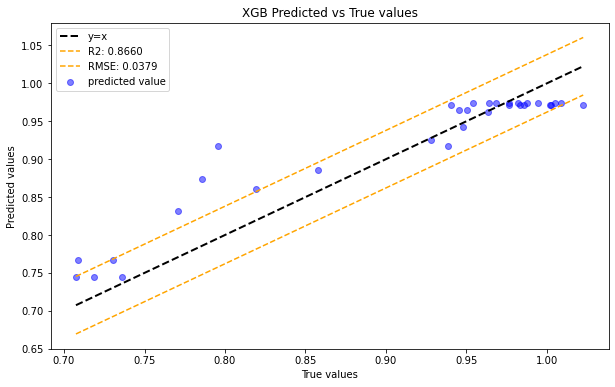

In [67]:
# 绘制预测结果图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.plot([min(y_test), max(y_test)], [min(y_test) + rmse, max(y_test) + rmse], 'orange', linestyle='dashed')
plt.plot([min(y_test), max(y_test)], [min(y_test) - rmse, max(y_test) - rmse], 'orange', linestyle='dashed')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('XGB Predicted vs True values')
plt.legend(['y=x', f"R2: {r2:.4f}", f"RMSE: {rmse:.4f}", 'predicted value'], loc='best')
plt.show()

# lasso回归

In [68]:
# 读取数据
data = pd.read_excel('E:\\555.xlsx')

In [69]:
# 划分特征和目标变量
X = data.drop(columns=['self healingefficiency'])
y = data['self healingefficiency']

In [70]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
# 定义Lasso回归模型
def lasso(alpha):
    model = Lasso(alpha=alpha, max_iter=100)
# 使用5折交叉验证计算R方值
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()

In [72]:
# 使用贝叶斯优化寻找最佳参数
pbounds = {'alpha': (0.001, 0.1)}
optimizer = BayesianOptimization(f=lasso, pbounds=pbounds,random_state=42,allow_duplicate_points=True)
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | -0.2013   | 0.03808   |
| 2         | -0.2013   | 0.09512   |
| 3         | -0.2013   | 0.07347   |
| 4         | -0.2013   | 0.06027   |
| 5         | 0.5155    | 0.01645   |
| 6         | 0.5156    | 0.01644   |
| 7         | 0.7001    | 0.00675   |
| 8         | -0.2013   | 0.08675   |
| 9         | -0.2013   | 0.06051   |
| 10        | -0.2013   | 0.0711    |
| 11        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

| 12        | 0.7314    | 0.002144  |
Data point [0.001] is not unique. 1 duplicates registered. Continuing ...
| 13        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 2 duplicates registered. Continuing ...
| 14        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 3 duplicates registered. Continuing ...
| 15        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 4 duplicates registered. Continuing ...
| 16        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 5 duplicates registered. Continuing ...
| 17        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 6 duplicates registered. Continuing ...
| 18        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 7 duplicates registered. Continuing ...
| 19        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 8 duplicates registered. Continuing ...
| 20        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 9 duplicates registered. Continuing ...
| 21        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 10 duplicates registered. Continuing ...
| 22        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 11 duplicates registered. Continuing ...
| 23        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 12 duplicates registered. Continuing ...
| 24        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 13 duplicates registered. Continuing ...
| 25        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 14 duplicates registered. Continuing ...
| 26        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 15 duplicates registered. Continuing ...
| 27        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 16 duplicates registered. Continuing ...
| 28        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 17 duplicates registered. Continuing ...
| 29        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 18 duplicates registered. Continuing ...
| 30        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 19 duplicates registered. Continuing ...
| 31        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 20 duplicates registered. Continuing ...
| 32        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 21 duplicates registered. Continuing ...
| 33        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 22 duplicates registered. Continuing ...
| 34        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 23 duplicates registered. Continuing ...
| 35        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 24 duplicates registered. Continuing ...
| 36        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 25 duplicates registered. Continuing ...

D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.019e-04, tolerance: 5.922e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.194e-04, tolerance: 5.538e-05
  model = cd_fast.enet_


| 37        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 26 duplicates registered. Continuing ...
| 38        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e-04, tolerance: 5.310e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_

Data point [0.001] is not unique. 27 duplicates registered. Continuing ...
| 39        | 0.7339    | 0.001     |
Data point [0.001] is not unique. 28 duplicates registered. Continuing ...
| 40        | 0.7339    | 0.001     |


D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-04, tolerance: 5.013e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-04, tolerance: 5.817e-05
  model = cd_fast.enet_coordinate_descent(
D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.019e-04, tolerance: 5.922e-05
  model = cd_fast.enet_

In [73]:
# 输出最佳参数和最大R方值
print("Best Parameters:", optimizer.max['params'])
print("Best R2 Score:", optimizer.max['target'])

Best Parameters: {'alpha': 0.001}
Best R2 Score: 0.733938142644151


In [74]:
# 使用最佳参数训练模型并在测试集上进行测试
lasso_model = Lasso(alpha=optimizer.max['params']['alpha'], max_iter=100)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

D:\annacoda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.526e-04, tolerance: 6.943e-05
  model = cd_fast.enet_coordinate_descent(


In [75]:
# 计算RMSE和R方
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 输出测试结果
print("Test RMSE:", rmse)
print("Test R2 Score:", r2)

Test RMSE: 0.04659735079231942
Test R2 Score: 0.7980176780318046


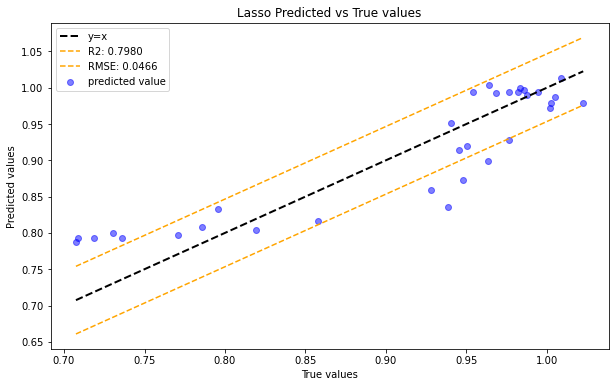

In [76]:
# 绘制预测结果图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.plot([min(y_test), max(y_test)], [min(y_test) + rmse, max(y_test) + rmse], 'orange', linestyle='dashed')
plt.plot([min(y_test), max(y_test)], [min(y_test) - rmse, max(y_test) - rmse], 'orange', linestyle='dashed')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Lasso Predicted vs True values')
plt.legend(['y=x', f"R2: {r2:.4f}", f"RMSE: {rmse:.4f}", 'predicted value'], loc='best')
plt.show()

# svm

In [77]:
# 读取数据
data = pd.read_excel('E:\\555.xlsx')

In [78]:
# 划分特征和目标变量
X = data.drop(columns=['self healingefficiency'])
y = data['self healingefficiency']

In [79]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
# 定义SVM模型函数
def svm_model(C, epsilon):
    model = SVR(C=C, epsilon=epsilon)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()

In [81]:
# 定义优化函数
def optimize_svm():
    def svm_crossval(C, epsilon):
        return svm_model(C, epsilon)

    optimizer = BayesianOptimization(
        f=svm_crossval,
        pbounds={'C': (1, 5), 'epsilon': (0.01, 0.1)},
        verbose=2,
        random_state=42
    )
    optimizer.maximize(init_points=10, n_iter=30)

    return optimizer.max

In [82]:
best_params = optimize_svm()

|   iter    |  target   |     C     |  epsilon  |
-------------------------------------------------
| 1         | 0.5482    | 2.498     | 0.09556   |
| 2         | 0.8426    | 3.928     | 0.06388   |
| 3         | 0.9184    | 1.624     | 0.02404   |
| 4         | 0.6477    | 1.232     | 0.08796   |
| 5         | 0.7924    | 3.404     | 0.07373   |
| 6         | 0.5247    | 1.082     | 0.09729   |
| 7         | 0.91      | 4.33      | 0.02911   |
| 8         | 0.915     | 1.727     | 0.02651   |
| 9         | 0.8508    | 2.217     | 0.05723   |
| 10        | 0.8917    | 2.728     | 0.03621   |
| 11        | 0.9227    | 2.907     | 0.02193   |
| 12        | 0.4931    | 1.974     | 0.1       |
| 13        | 0.8516    | 1.405     | 0.05695   |
| 14        | 0.889     | 4.161     | 0.04368   |
| 15        | 0.4948    | 3.073     | 0.09987   |
| 16        | 0.9159    | 2.898     | 0.02529   |
| 17        | 0.9179    | 2.897     | 0.02452   |
| 18        | 0.6017    | 4.499     | 0.09151   |


In [83]:
# 使用最佳参数进行训练和测试
svm_model = SVR(C=best_params['params']['C'], epsilon=best_params['params']['epsilon'])
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [84]:
# 计算RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [85]:
# 输出测试结果
print("Test RMSE:", rmse)
print("Test R2 Score:", r2)

Test RMSE: 0.035386963587646744
Test R2 Score: 0.8835129877928608


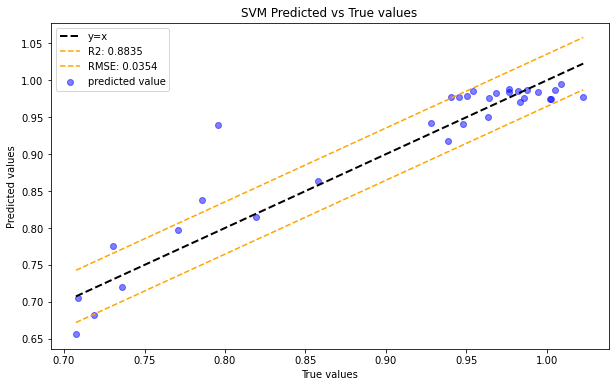

In [86]:
# 绘制预测结果图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.plot([min(y_test), max(y_test)], [min(y_test) + rmse, max(y_test) + rmse], 'orange', linestyle='dashed')
plt.plot([min(y_test), max(y_test)], [min(y_test) - rmse, max(y_test) - rmse], 'orange', linestyle='dashed')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('SVM Predicted vs True values')
plt.legend(['y=x', f"R2: {r2:.4f}", f"RMSE: {rmse:.4f}", 'predicted value'], loc='best')
plt.show()

In [124]:
# 读取数据
data = pd.read_excel('E:\\888.xlsx')

In [125]:
# 划分特征和目标变量
X = data.drop(columns=['self healingefficiency'])
y = data['self healingefficiency']

In [126]:
y_pred = rf_model.predict(X)

In [127]:
print(y_pred)

[0.96297624 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624
 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624
 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624
 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624 0.96297624
 0.96297624 0.96297624 0.96341224 0.96341224 0.96341224 0.96341224
 0.96341224 0.96341224 0.96341224 0.96341224 0.96341224 0.96341224
 0.96379276 0.96379276 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221
 0.96429221 0.96429221 0.96429221 0.96429221 0.96429221 0.9642

In [128]:
df = pd.DataFrame(y_pred)

In [129]:
print(df)

            0
0    0.962976
1    0.962976
2    0.962976
3    0.962976
4    0.962976
..        ...
196  0.964292
197  0.964292
198  0.964292
199  0.964292
200  0.964292

[201 rows x 1 columns]


In [116]:
merged_df = pd.concat([data, df], ignore_index=True)

In [118]:
merged_df.to_excel('E:\\888.xlsx', index=False)